In [494]:
# 336

In [100]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from skopt import Optimizer
from skopt.plots import plot_objective, plot_gaussian_process
from skopt.space import Categorical, Integer, Real
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel
import matplotlib.pyplot as plt

In [119]:
class CapstoneOptimise():
    def __init__(self, function_num, dimensions, custom_GP_model=False, noise_assumption=1e-10, rbf_lengthscale=0.4, base_estimator="GP", n_initial_points=10, acq_optimizer="auto", acq_func="gp_hedge", acq_func_kwargs=None, random_state=1):
        self.X = np.load(f'initial_data/function_{function_num}/initial_inputs.npy')
        self.y = -np.load(f'initial_data/function_{function_num}/initial_outputs.npy')
        self.fnum = function_num
        self.add_new_results()
            
        self.dimensions=dimensions
        self.lengthscale=rbf_lengthscale
        self.noise_assumption=noise_assumption
        self.custom_GP_model=custom_GP_model
        
        self.opt = Optimizer(
                dimensions=dimensions,
                base_estimator=base_estimator,
                n_initial_points=n_initial_points,
                acq_optimizer=acq_optimizer,
                acq_func=acq_func,
                acq_func_kwargs=acq_func_kwargs,
                random_state=random_state
        )
        
    
    def use_custom_GP_model(self):
        kernel = RBF(length_scale=self.lengthscale, length_scale_bounds='fixed')
        model = GaussianProcessRegressor(kernel=kernel, alpha=self.noise_assumption)

        self.opt.models.append(model)
        
    def add_new_results(self):
        for each in results[f'f{self.fnum}']:
            each = each.replace('[','').replace(']','')
            each = each.split(' ')
            each = [e for e in each if e != '']
            each = np.vectorize(float)(each)
            self.X = np.vstack((self.X, each))
        for each in results[f'f{self.fnum}_output']:
            self.y = np.append(self.y, -each)

    def observe(self):
        for X,y in zip(self.X, self.y):
            self.opt.tell(list(X), y)
#             print('Point evaluated: ', X,y)
        
    def suggest(self):
        self.observe()
        if self.custom_GP_model:
            self.use_custom_GP_model()
        next_x = self.opt.ask()
        self.format_for_submission(next_x)
           
    def format_for_submission(self, next_x):
        next_x = np.array(next_x)
        next_x = np.where(next_x == 1.0, 0.999999, next_x)
        print('Next point to evaluate: ', '-'.join(['{:0.6f}'.format(num) for num in next_x]))
    
    def print_opt_settings(self):
        print('')
        print('--------SETTINGS--------')
        print(self.opt.get_result())
    
    def visualise(self):
        ax = plot_objective(
            self.opt.get_result(), 
#             minimum="expected_minimum"
        )
        
        
        
        
        

In [102]:
results = pd.read_csv('336_data_week3.csv')
results

,Unnamed: 0,timestamp,student_id,f1,f2,f3,f4,f5,f6,f7,f8,f1_output,f2_output,f3_output,f4_output,f5_output,f6_output,f7_output,f8_output
0,15,2023-09-05 10:26:18,336,[0.705514 0.43912 ],[0.965024 0.91536 ],[0.16266 0.866048 0.667268],[0. 0. 0.999999 0.999999],[0. 0.697069 0.999999 0.999999],[0.4221 0.142776 0.80204 0.999999 0. ],[0.02335 0.50997 0.636946 0.221067 0.404118 ...,[0.062098 0.001214 0.125141 0. 0.999999 ...,-4.879372e-30,0.029249,-0.151253,-40.348376,2173.075256,-0.654542,1.518506,9.845629
1,35,2023-09-12 10:32:45,336,[0.368328 0.039749],[0.740257 0.023022],[0.17457 0.173746 0. ],[0.408187 0.394678 0.367648 0.429217],[0. 0.557409 0.999999 0.999999],[0.555141 0.224629 0.612285 0.828901 0.02721 ],[0. 0.335599 0.999999 0.199346 0.362958 ...,[0.123935 0.151296 0.166346 0.040579 0.999999 ...,2.959938e-104,0.442687,-0.138356,0.504187,1839.133437,-0.461623,1.082019,9.936734


### Function 1 - 2D

#### Searching for Contamination Sources

This may sound simple because you only have a two-dimensional input, however it is a very difficult problem. It corresponds to trying to find the source of radiation in some square area. However, you can only detect the radiation once you are very close to it, meaning most of the readings will be zero. There are two sources, one is not too dangerous, so make sure you try to find both modes of the function.

Next point to evaluate:  0.788469-0.651327


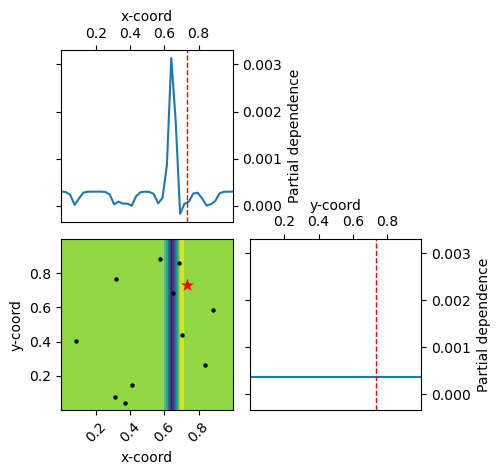

In [128]:
space = [Real(0, 1, name='x-coord'), Real(0, 1, name='y-coord')]  # 2D input space

optimizer = CapstoneOptimise(
    function_num=1, 
    dimensions=space,
#     custom_GP_model=True,
    rbf_lengthscale=0.1,
    acq_func="LCB",
    acq_func_kwargs={
        "kappa": 4
    }
)
optimizer.suggest()

optimizer.visualise()
# optimizer.print_opt_settings()

##### Notes

- There are 2 modes - 2 optima however one more dangerous (larger) than the other
- Can only detect radiation when very close - might need to be explorative initially to find new places where the function peaks and need a low lengthscale as the radiation level suddenly spikes - essentially an outlier and we want to fit to it to find it

--- 

### Function 2 - 2D

#### Optimising Noisy Models

This corresponds to trying to optimise an unknown machine learning model. However, the initialization of the model is very important, meaning your observations will be very noisy, and the problem might have a lot of local optima! You are trying to make the model’s log-likelihood as large as possible.

Next point to evaluate:  0.000000-0.999412


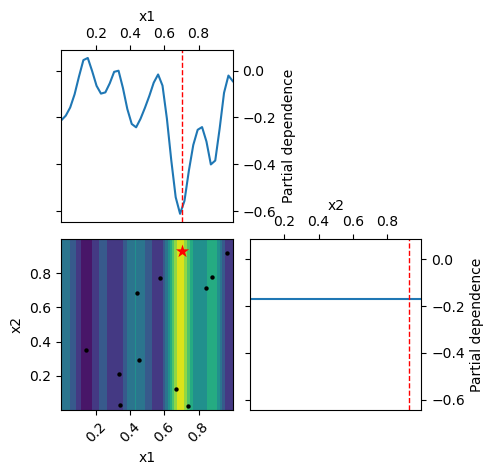

In [129]:
space = [Real(0, 1, name='x1'), Real(0, 1, name='x2')]  # 2D input space

optimizer = CapstoneOptimise(
    function_num=2, 
    dimensions=space, 
#     custom_GP_model=True, 
    acq_func="LCB", 
    noise_assumption=0.1, 
    rbf_lengthscale=0.35,
    acq_func_kwargs={ 
        "kappa": 6
    }
)
optimizer.suggest()

optimizer.visualise()
# optimizer.print_opt_settings()

##### Notes

- Has a lot of local optima, and we don't want to fit to it as we would be overfitting noise. May need a longer lengthspace with the GP kernel used
- Is noisy - needs higher noise assumption
- Use LCB initially as it probably needs a more explorative approach with the high noise
- Mentions log-likelihood, what is this?
- x1 seems to be generating noise with x2 being less noisy

--- 

### Function 3 - 3D

#### Drug Discovery Problem

In this example, you are doing drug discovery! You can select three compounds to create a drug, and receive a measurement of the people’s adverse reaction to the drug. You want to make this as close as possible to zero. (hint: one of the variables may not cause any effects on the person).

Next point to evaluate:  0.973650-0.851858-0.847307


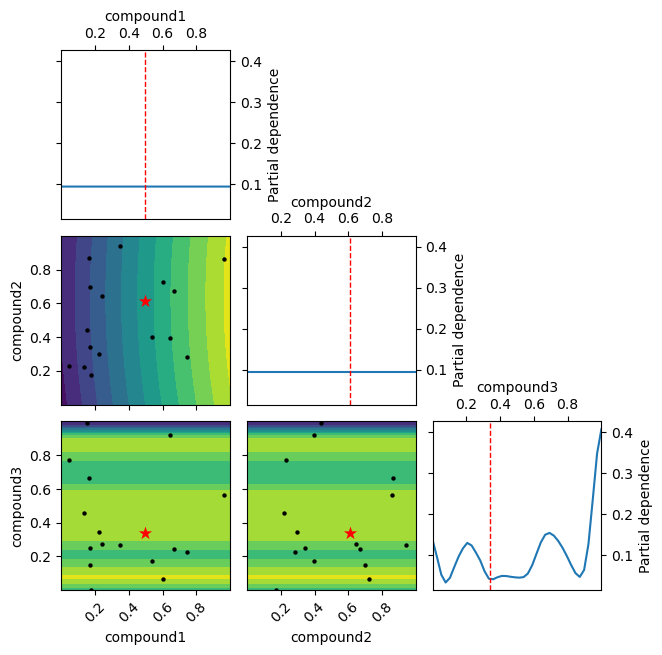

In [130]:
space = [Real(0, 1, name='compound1'), Real(0, 1, name='compound2'), Real(0, 1, name='compound3')]  # 3D input space

optimizer = CapstoneOptimise(
    function_num=3, 
    dimensions=space,
    acq_func="EI",
    acq_func_kwargs={
        "xi": 0.5
    }
)
optimizer.suggest()

optimizer.visualise()
# optimizer.print_opt_settings()

##### Notes

- Feature engineering necessary? As one variable may not cause any effects
- Would an adverse reaction be noisy?
- Want to find closest to zero but the y vals are all negative therefore it is still a maximisation problem

--- 

### Function 4 - 4D

#### Fast, but Inaccurate Modelling

This example is for a particular business relying heavily on online sales. It can run very accurate calculations to figure out what is the optimal placement of their product across warehouses. Unfortunately, the calculations are extremely expensive (computationally) to run, so they can only do it once every two weeks. Instead, they propose using a machine learning model which approximates the solution quickly (in a few hours). The model has four hyper-parameters you need to tune, and the output corresponds to the difference between the expensive calculation, and the model. Since you are modelling a dynamical system, expect a lot of local optima!

Next point to evaluate:  0.473930-0.457826-0.060740-0.429617


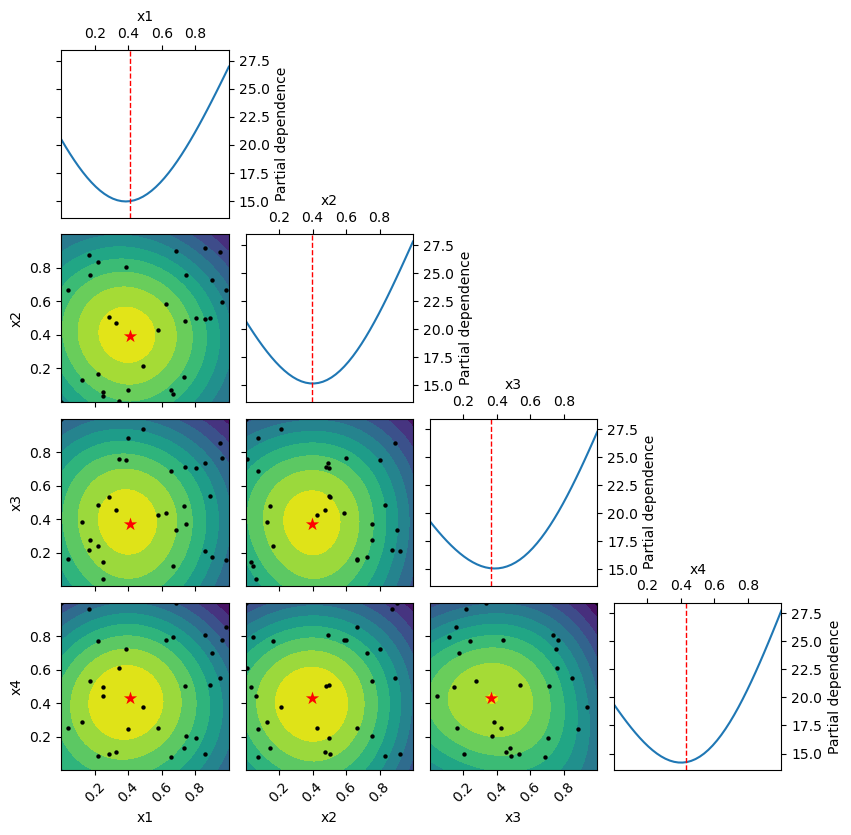

In [131]:
space = [Real(0, 1, name='x1'), Real(0, 1, name='x2'), Real(0, 1, name='x3'), Real(0, 1, name='x4')]  # 4D input space

optimizer = CapstoneOptimise(
    function_num=4, 
    dimensions=space,
#     custom_GP_model=True,
    rbf_lengthscale=0.35,
    acq_func="LCB",
    acq_func_kwargs={
        "kappa": 5
    }
)
optimizer.suggest()

optimizer.visualise()
# optimizer.print_opt_settings()

##### Notes

- The output wants to be as close to zero as possible - as we want it to be as similar to the expensive calculation as possible - still maximisation as y vals are negative
- Lots of local optima we want to smooth - explorative and longer lengthscale

--- 

### Function 5 - 4D

#### Yield in a Chemical Reaction

This time you are trying to optimise another four-dimensional black-box. It corresponds to the yield of a chemical process after processing in some factory. This type of process tends to be unimodal. Try to find the combination of chemicals that maximizes the yield!

Next point to evaluate:  0.999999-0.000000-0.999999-0.999999


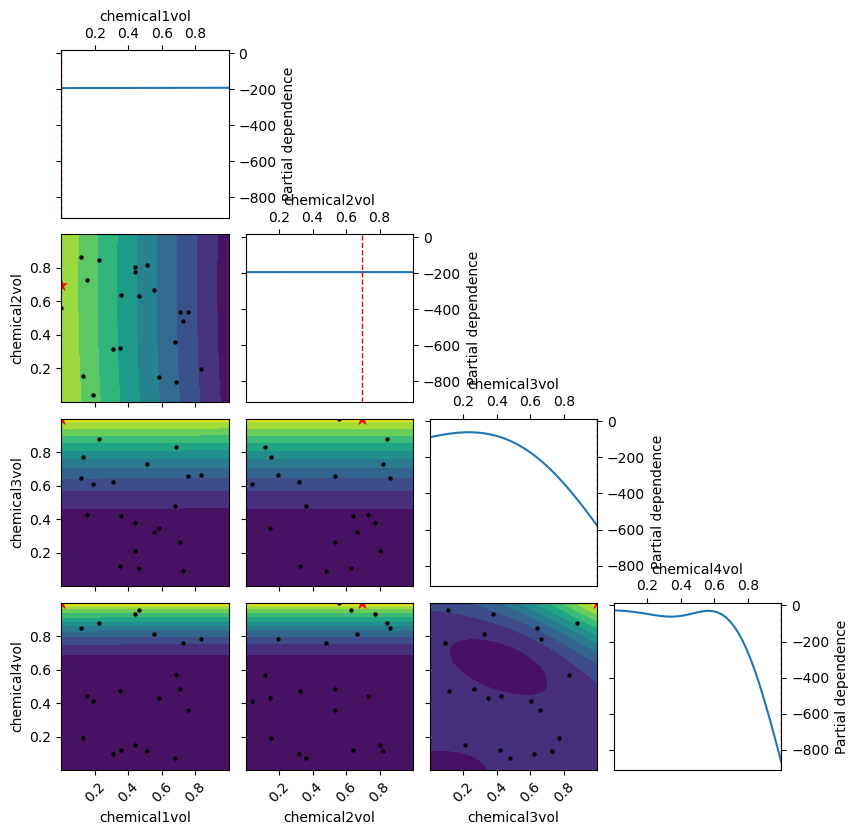

In [132]:
space = [Real(0, 1, name='chemical1vol'), Real(0, 1, name='chemical2vol'), Real(0, 1, name='chemical3vol'), Real(0, 1, name='chemical4vol')]  # 4D input space

optimizer = CapstoneOptimise(
    function_num=5, 
    dimensions=space,
#     custom_GP_model=True,
    rbf_lengthscale=0.4,
    acq_func="PI"
)
optimizer.suggest()

optimizer.visualise()
# optimizer.print_opt_settings()

##### Notes

- Unimodal - so lengthscale can be quite large as all points will be more or less correlated.
- Doesn't need to be as exploratory

--- 

### Function 6  - 5D

#### Cake and stuff

Time to get cooking! You are optimising a cake recipe. There are five ingredients. The outputs correspond to the sum of different objectives: flavor, consistency, calories, waste and cost. Each objective receives negative points by our expert taster. You want this sum to be as close to zero as possible!

Next point to evaluate:  0.471321-0.366038-0.329932-0.999999-0.000000


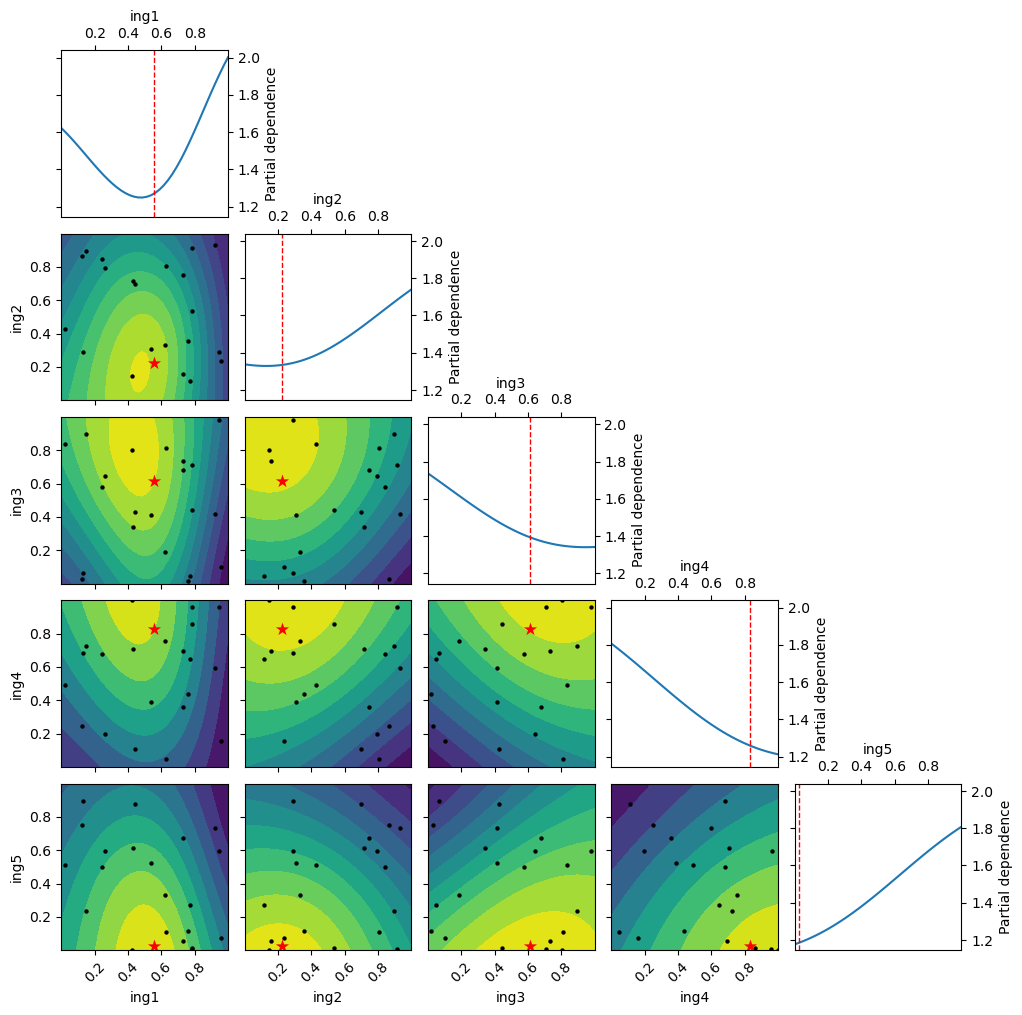

In [133]:
space = [Real(0, 1, name='ing1'), Real(0, 1, name='ing2'), Real(0, 1, name='ing3'), Real(0, 1, name='ing4'), Real(0, 1, name='ing5')]  # 5D input space

optimizer = CapstoneOptimise(
    function_num=6, 
    dimensions=space
)
optimizer.suggest()

optimizer.visualise()
# optimizer.print_opt_settings()

##### Notes

- Don't know what the function looks like for now so best to use default settings

--- 

### Function 7 - 6D

#### Sometimes Lazy is Best

You are now optimising six hyper-parameters of a machine learning model. Note that it is a popular and frequently used model, so maybe you could search to see if anyone else has optisized it before?

Next point to evaluate:  0.000000-0.597242-0.905742-0.088994-0.384408-0.743014


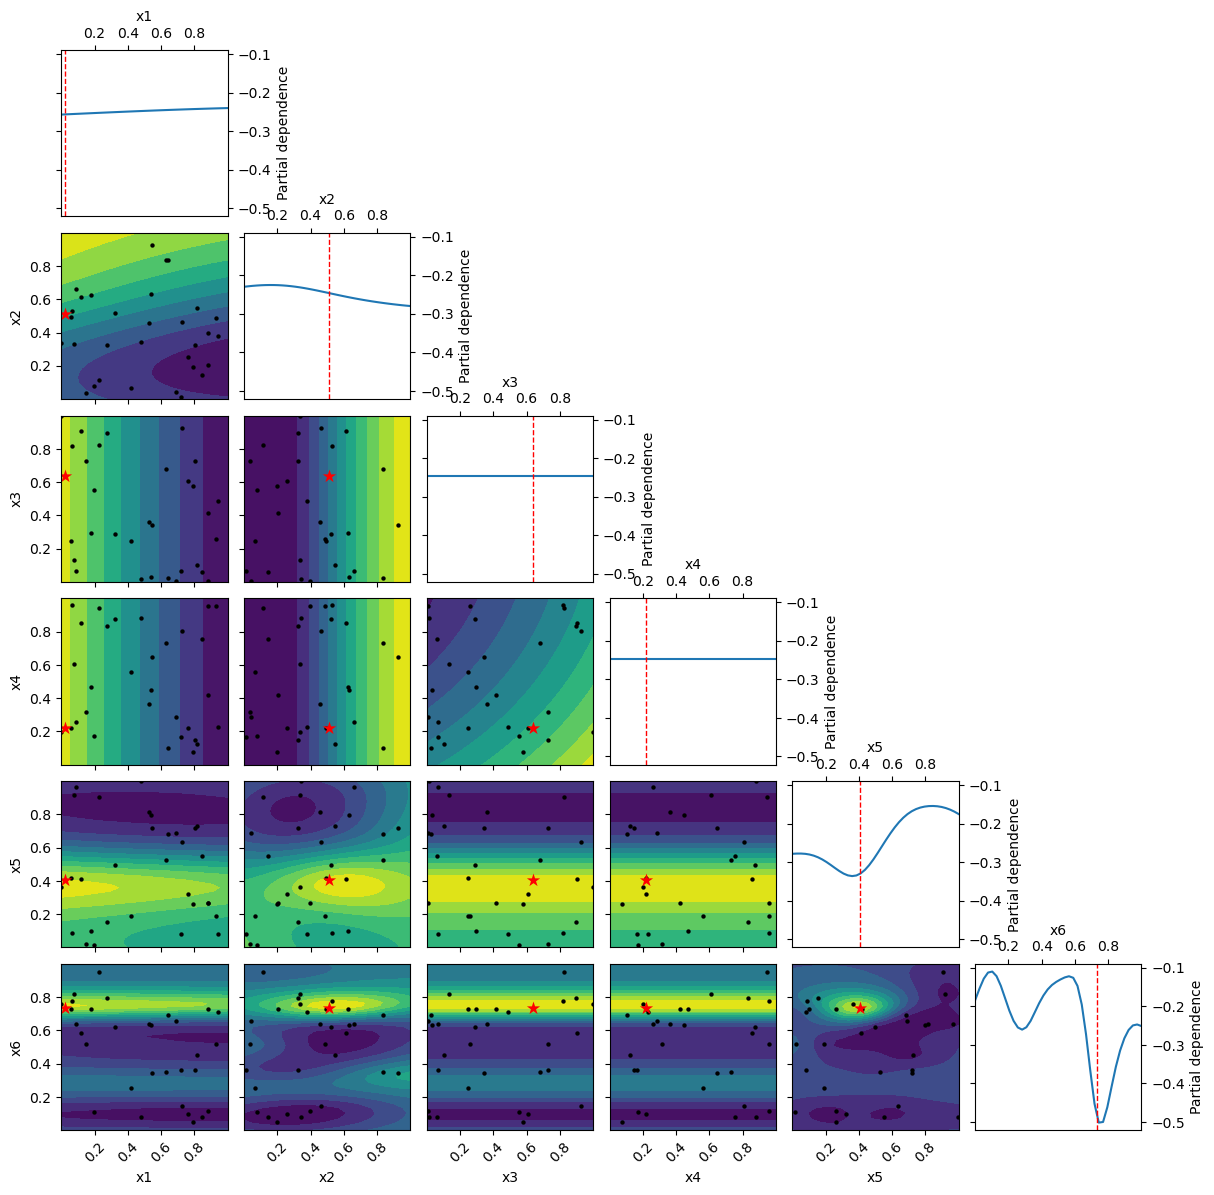

In [134]:
space = [Real(0, 1, name='x1'), Real(0, 1, name='x2'), Real(0, 1, name='x3'), Real(0, 1, name='x4'), Real(0, 1, name='x5'), Real(0, 1, name='x6')]  # 6D input space

optimizer = CapstoneOptimise(
    function_num=7, 
    dimensions=space
)
optimizer.suggest()

optimizer.visualise()
# optimizer.print_opt_settings()

##### Notes

- Look at models we have used before to see which one could be 6D - iris, cancer, diabetes, income pred, boston housing ?? 




---

### Function 8 - 8D

#### High-dimensional Optimisation

You’ve reach the final, 8-dimensional search space. High-dimensional black-box optimisation can be very difficult, so sticking to local solutions is not the worst idea here.

Next point to evaluate:  0.098974-0.327035-0.000000-0.260515-0.999999-0.000000-0.179025-0.999999


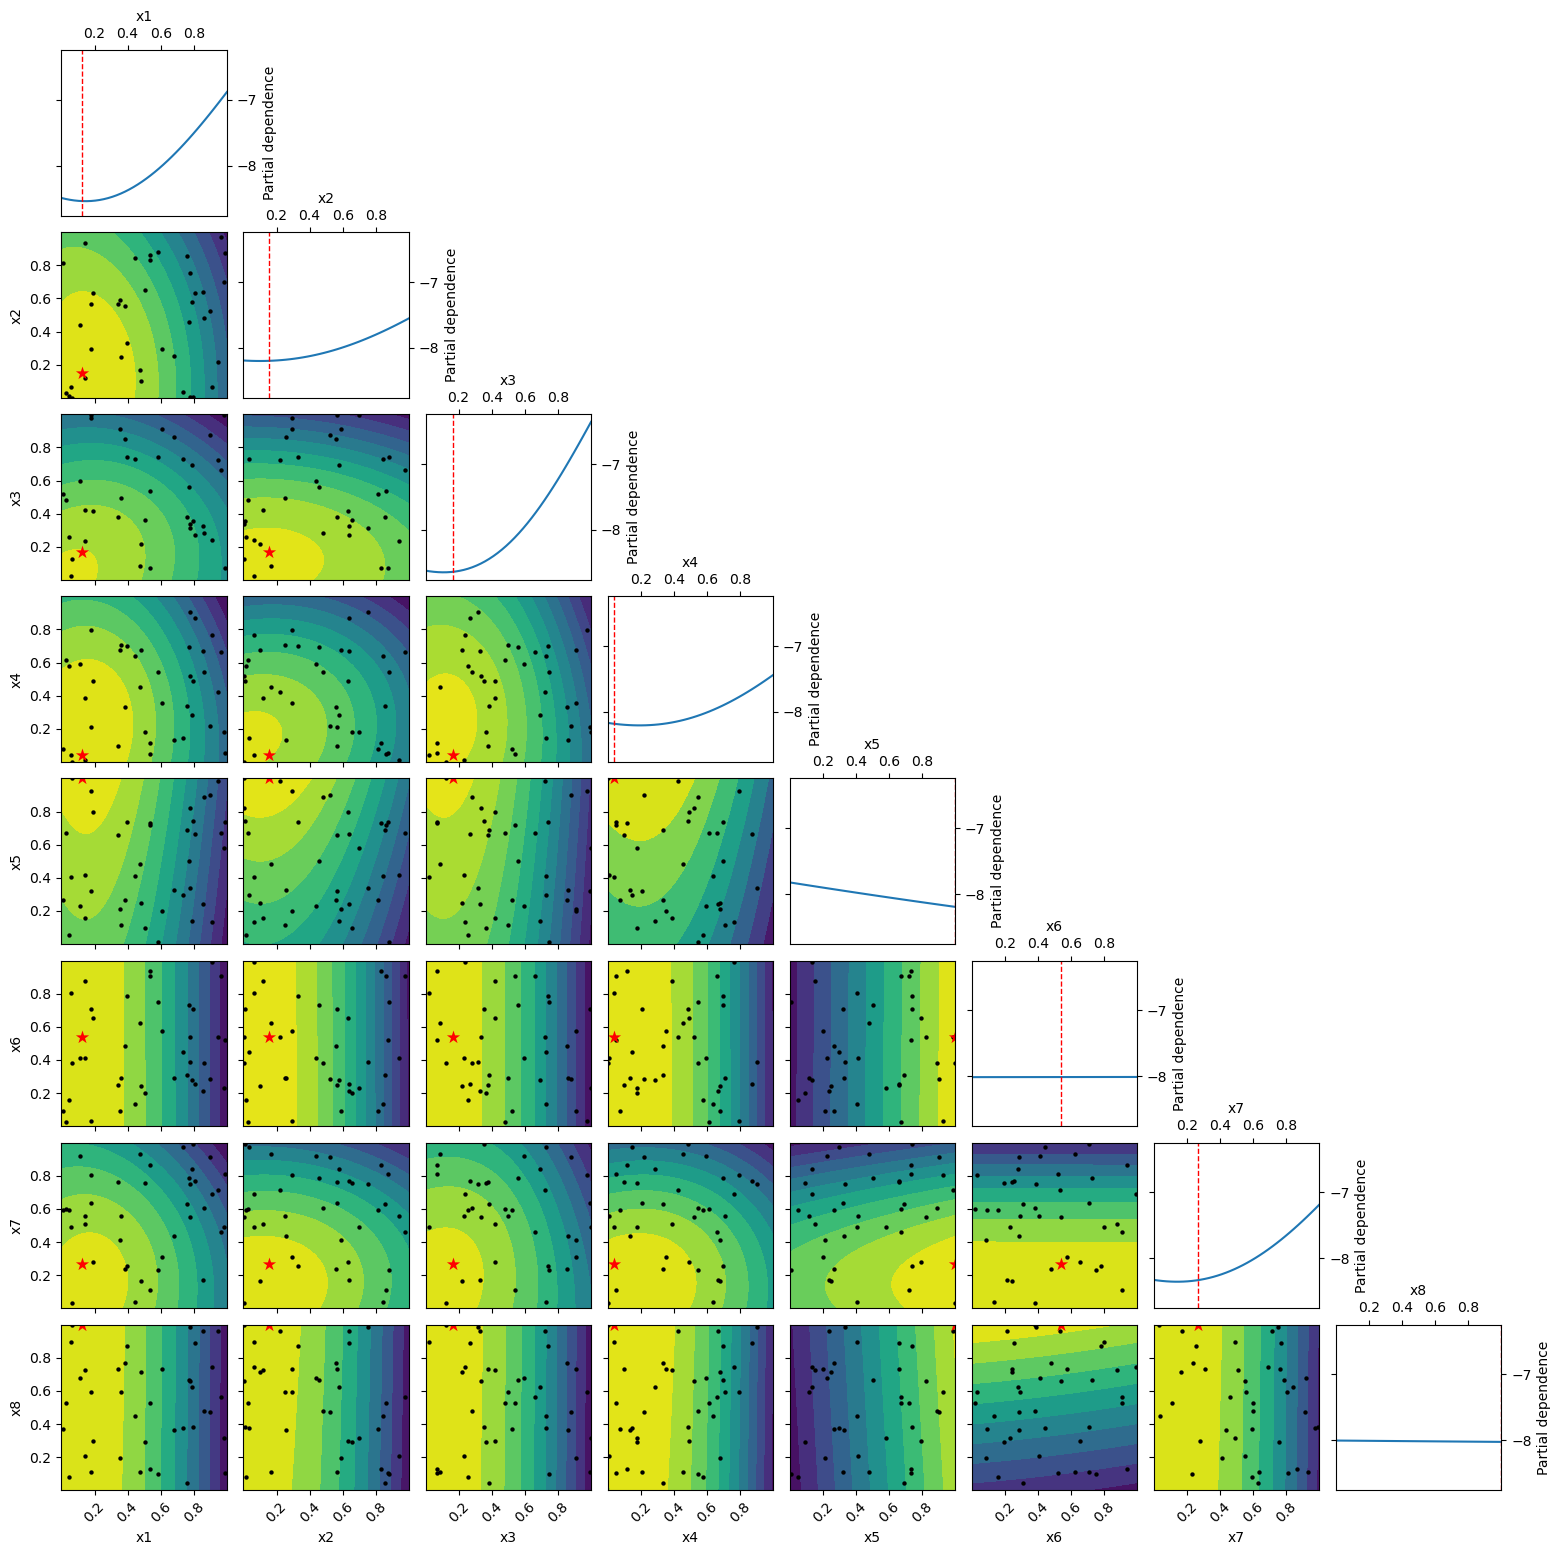

In [135]:
space = [Real(0, 1, name='x1'), Real(0, 1, name='x2'), Real(0, 1, name='x3'), Real(0, 1, name='x4'), Real(0, 1, name='x5'), Real(0, 1, name='x6'), Real(0, 1, name='x7'), Real(0, 1, name='x8')]  # 8D input space

optimizer = CapstoneOptimise(
    function_num=8, 
    dimensions=space
)
optimizer.suggest()

optimizer.visualise()
# optimizer.print_opt_settings()

##### Notes

- May be better to be balanced at first, and then exploitative, as it says local solutions would be a good idea here